In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from collections import Counter

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df1 = pd.read_csv(r'C:\Users\DELL\Desktop\final_datasets\dataset2\accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)

In [ ]:
df2= pd.read_csv(r'C:\Users\DELL\Desktop\final_datasets\dataset2\rejected_2007_to_2018Q4.csv.gz', low_memory=True)

In [ ]:
loans_accepted=df1.copy()

In [ ]:
df1['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

In [ ]:
loans_accepted.shape

(2260701, 151)

In [ ]:
loans_accepted['issue_d'].head()

0    Dec-2015
1    Dec-2015
2    Dec-2015
3    Dec-2015
4    Dec-2015
Name: issue_d, dtype: object

In [ ]:
loans_accepted = loans_accepted.loc[loans_accepted['loan_status'].isin(['Fully Paid', 'Charged Off'])]
loans_accepted['fico_score'] = 0.5*loans_accepted['fico_range_low'] + 0.5*loans_accepted['fico_range_high']
loans_accepted.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)
keep_list = [ 'loan_amnt','issue_d','purpose','fico_score','dti','emp_length','addr_state','emp_length','loan_status']
drop_list = [col for col in loans_accepted.columns if col not in keep_list]
loans_accepted.drop(labels=drop_list, axis=1, inplace=True)
loans_accepted['Class'] = (loans_accepted['loan_status'] == 'Charged Off').apply(np.uint8)
loans_accepted.drop('loan_status', axis=1, inplace=True)
loans_accepted['emp_length']=loans_accepted['emp_length'].replace({'< 1 year': 'les1year'})
loans_accepted['issue_d'] = loans_accepted['issue_d'].str.extract(r'-(\d{4})').astype(int)
loans_accepted=loans_accepted.dropna()
loans_accepted.head()

,loan_amnt,emp_length,issue_d,purpose,addr_state,dti,fico_score,Class
0,3600.0,10+ years,2015,debt_consolidation,PA,5.91,677.0,0
1,24700.0,10+ years,2015,small_business,SD,16.06,717.0,0
2,20000.0,10+ years,2015,home_improvement,IL,10.78,697.0,0
4,10400.0,3 years,2015,major_purchase,PA,25.37,697.0,0
5,11950.0,4 years,2015,debt_consolidation,GA,10.20,692.0,0


In [ ]:
loans_rejected=df2.copy()

In [ ]:
loans_rejected.shape

(27648741, 9)

In [ ]:
loans_rejected.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [ ]:
loans_rejected.drop(labels=['Zip Code','Policy Code'], axis=1, inplace=True)
loans_rejected.columns = ['loan_amnt', 'issue_d','purpose','fico_score','dti','addr_state','emp_length']
loans_rejected=loans_rejected.dropna()
loans_rejected['dti'] = list(map(lambda x: x[:-1], loans_rejected['dti'].values))
loans_rejected['dti'] = [float(x) for x in loans_rejected['dti'].values]
loans_rejected['Class']=-1
loans_rejected = loans_rejected[['loan_amnt','emp_length', 'issue_d','purpose','addr_state','dti','fico_score','Class']]
options=['debt_consolidation','credit_card','home_improvement','house','medical','other','car','major_purchase'
,'moving','small_business','vacation','renewable_energy','wedding','educational']
loans_rejected = loans_rejected[loans_rejected['purpose'].isin(options)]
loans_rejected['issue_d'] = pd.to_datetime(loans_rejected['issue_d']).dt.year
loans_rejected = loans_rejected.drop(loans_rejected[loans_rejected.dti > 999].index)
loans_rejected = loans_rejected.drop(loans_rejected[loans_rejected.loan_amnt > 40000].index)
loans_rejected = loans_rejected.drop(loans_rejected[loans_rejected.fico_score < 627].index) 
loans_rejected['emp_length']=loans_rejected['emp_length'].replace({'< 1 year': 'les1year'})
loans_rejected.head()

,loan_amnt,emp_length,issue_d,purpose,addr_state,dti,fico_score,Class
3015,5000.0,4 years,2007,other,NJ,17.81,628.0,-1
3016,6000.0,8 years,2007,other,NJ,35.13,674.0,-1
3017,20000.0,8 years,2007,debt_consolidation,FL,36.92,710.0,-1
3018,10000.0,10+ years,2007,debt_consolidation,NY,63.88,631.0,-1
3020,2000.0,6 years,2007,debt_consolidation,MA,30.53,696.0,-1


In [ ]:
loans_accepted.shape

(1266782, 8)

In [ ]:
loans_rejected.shape

(2064314, 8)

In [ ]:
loans_accepted.columns

Index(['loan_amnt', 'emp_length', 'issue_d', 'purpose', 'addr_state', 'dti',
       'fico_score', 'Class'],
      dtype='object')

In [ ]:
loans_accepted.shape

(1266782, 8)

In [ ]:
loans_rejected.shape

(2064314, 8)

In [ ]:
loans_accepted['Class'].value_counts(normalize=True)

Class
0    0.804681
1    0.195319
Name: proportion, dtype: float64

In [ ]:
loans_accepted.describe()

,loan_amnt,issue_d,dti,fico_score,Class
count,1.266782e+06,1.266782e+06,1.266782e+06,1.266782e+06,1.266782e+06
mean,1.460112e+04,2.014951e+03,1.812865e+01,6.981256e+02,1.953185e-01
std,8.746531e+03,1.645564e+00,9.569931e+00,3.166289e+01,3.964459e-01
min,5.000000e+02,2.007000e+03,-1.000000e+00,6.270000e+02,0.000000e+00
25%,8.000000e+03,2.014000e+03,1.176000e+01,6.720000e+02,0.000000e+00
50%,1.207500e+04,2.015000e+03,1.752000e+01,6.920000e+02,0.000000e+00
75%,2.000000e+04,2.016000e+03,2.391000e+01,7.120000e+02,0.000000e+00
max,4.000000e+04,2.018000e+03,9.990000e+02,8.475000e+02,1.000000e+00


In [ ]:
loans_rejected.describe()

,loan_amnt,issue_d,dti,fico_score,Class
count,2.064314e+06,2.064314e+06,2.064314e+06,2.064314e+06,2064314.0
mean,1.531566e+04,2.013734e+03,3.232090e+01,6.759921e+02,-1.0
std,1.078662e+04,1.435995e+00,4.951032e+01,3.781900e+01,0.0
min,1.000000e+03,2.007000e+03,-1.000000e+00,6.270000e+02,-1.0
25%,6.000000e+03,2.013000e+03,1.179000e+01,6.480000e+02,-1.0
50%,1.200000e+04,2.014000e+03,2.432000e+01,6.680000e+02,-1.0
75%,2.400000e+04,2.014000e+03,3.944000e+01,6.960000e+02,-1.0
max,4.000000e+04,2.017000e+03,9.984600e+02,9.900000e+02,-1.0


In [ ]:
loans_accepted.columns

Index(['loan_amnt', 'emp_length', 'issue_d', 'purpose', 'addr_state', 'dti',
       'fico_score', 'Class'],
      dtype='object')

In [ ]:
loans_rejected.columns

Index(['loan_amnt', 'emp_length', 'issue_d', 'purpose', 'addr_state', 'dti',
       'fico_score', 'Class'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
le_emp_length = LabelEncoder()
le_purpose = LabelEncoder()
le_addr=LabelEncoder()
# Fit on loans_accepted
le_emp_length.fit(loans_accepted['emp_length'])
le_purpose.fit(loans_accepted['purpose'])
#le_addr.fit(loans_accepted['addr_state'])
# Transform both datasets
loans_accepted['emp_length_encoded'] = le_emp_length.transform(loans_accepted['emp_length'])
loans_accepted['purpose_encoded'] = le_purpose.transform(loans_accepted['purpose'])
#loans_accepted['addr_state_encoded']=le_addr.transform(loans_accepted['addr_state'])
loans_rejected['emp_length_encoded'] = le_emp_length.transform(loans_rejected['emp_length'])
loans_rejected['purpose_encoded'] = le_purpose.transform(loans_rejected['purpose'])
#loans_rejected['addr_state_encoded']=le_addr.transform(loans_rejected['addr_state'])
# Drop original categorical columns (optional)
loans_accepted.drop(columns=['emp_length', 'purpose'], inplace=True)
loans_rejected.drop(columns=['emp_length', 'purpose'], inplace=True)

# Display result
print(loans_accepted.head())
print(loans_rejected.head())


   loan_amnt  issue_d addr_state    dti  fico_score  Class  \
0     3600.0     2015         PA   5.91       677.0      0   
1    24700.0     2015         SD  16.06       717.0      0   
2    20000.0     2015         IL  10.78       697.0      0   
4    10400.0     2015         PA  25.37       697.0      0   
5    11950.0     2015         GA  10.20       692.0      0   

   emp_length_encoded  purpose_encoded  
0                   1                2  
1                   1               11  
2                   1                4  
4                   3                6  
5                   4                2  
      loan_amnt  issue_d addr_state    dti  fico_score  Class  \
3015     5000.0     2007         NJ  17.81       628.0     -1   
3016     6000.0     2007         NJ  35.13       674.0     -1   
3017    20000.0     2007         FL  36.92       710.0     -1   
3018    10000.0     2007         NY  63.88       631.0     -1   
3020     2000.0     2007         MA  30.53       696.0  

In [ ]:
loans_accepted['Class'].value_counts(normalize=True)

Class
0    0.804681
1    0.195319
Name: proportion, dtype: float64

In [ ]:
loans_accepted.head()

,loan_amnt,issue_d,addr_state,dti,fico_score,Class,emp_length_encoded,purpose_encoded
0,3600.0,2015,PA,5.91,677.0,0,1,2
1,24700.0,2015,SD,16.06,717.0,0,1,11
2,20000.0,2015,IL,10.78,697.0,0,1,4
4,10400.0,2015,PA,25.37,697.0,0,3,6
5,11950.0,2015,GA,10.20,692.0,0,4,2


In [ ]:
loans_rejected=loans_rejected.drop(['Class'],axis=1)


In [ ]:
import pandas as pd

# Convert to DataFrame explicitly (though they should already be DataFrames)
loans_accepted = pd.DataFrame(loans_accepted)
loans_rejected = pd.DataFrame(loans_rejected)

# Display info to confirm
print(loans_accepted.info())
print(loans_rejected.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1266782 entries, 0 to 2260697
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   loan_amnt           1266782 non-null  float64
 1   issue_d             1266782 non-null  int32  
 2   addr_state          1266782 non-null  object 
 3   dti                 1266782 non-null  float64
 4   fico_score          1266782 non-null  float64
 5   Class               1266782 non-null  uint8  
 6   emp_length_encoded  1266782 non-null  int32  
 7   purpose_encoded     1266782 non-null  int32  
dtypes: float64(3), int32(3), object(1), uint8(1)
memory usage: 64.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2064314 entries, 3015 to 27648426
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loan_amnt           float64
 1   issue_d             int32  
 2   addr_state          object 
 3   dti                 floa

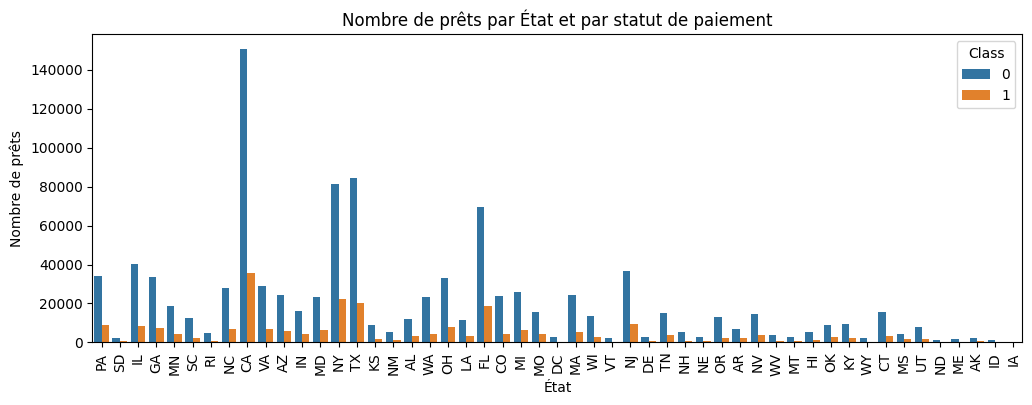

In [ ]:
plt.figure(figsize=(12, 4))

sns.countplot(data=loans_accepted, x='addr_state', hue='Class')

plt.xlabel('État')
plt.ylabel('Nombre de prêts')
plt.title('Nombre de prêts par État et par statut de paiement')
plt.xticks(rotation=90)

plt.show()


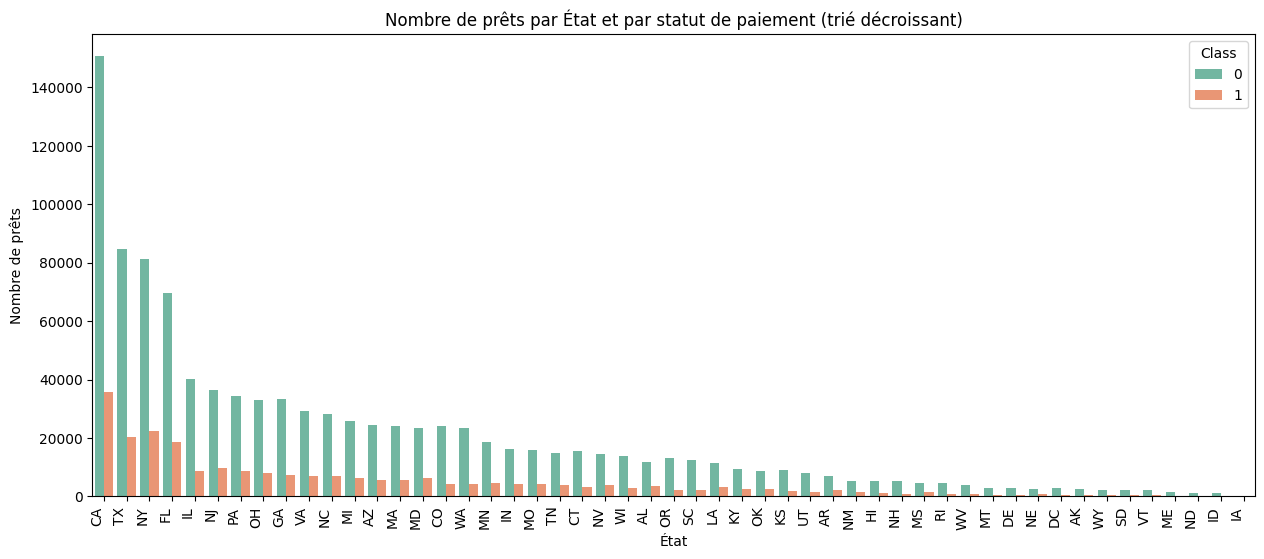

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Trier les États par nombre total de prêts en ordre décroissant
state_order = loans_accepted['addr_state'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(15, 6))  # Ajuster la taille pour une meilleure lisibilité

# Tracer le graphique avec les États triés
sns.countplot(data=loans_accepted, x='addr_state', hue='Class', order=state_order, palette="Set2")

# Ajouter des labels et un titre
plt.xlabel('État')
plt.ylabel('Nombre de prêts')
plt.title('Nombre de prêts par État et par statut de paiement (trié décroissant)')

# Rotation des labels pour éviter le chevauchement
plt.xticks(rotation=90, ha='right')

# Afficher le graphique
plt.show()


In [ ]:
# Filtrer uniquement les prêts où Class == 0
class_0_counts = loans_accepted[loans_accepted['Class'] == 0]['addr_state'].value_counts()

# Trier les États par nombre de prêts Class == 0 en ordre décroissant
class_0_counts_sorted = class_0_counts.sort_values(ascending=False)

# Diviser les États en 3 groupes de taille égale
n = len(class_0_counts_sorted)
group_1 = class_0_counts_sorted[:n//3].index.tolist()  # Top 1/3
group_2 = class_0_counts_sorted[n//3:2*n//3].index.tolist()  # Milieu 1/3
group_3 = class_0_counts_sorted[2*n//3:].index.tolist()  # Dernier 1/3

# Afficher les groupes
print("🔹 Groupe 1 (États avec le plus de Class 0) :\n", group_1)
print("\n🔸 Groupe 2 (États intermédiaires) :\n", group_2)
print("\n⚫ Groupe 3 (États avec le moins de Class 0) :\n", group_3)


🔹 Groupe 1 (États avec le plus de Class 0) :
 ['CA', 'TX', 'NY', 'FL', 'IL', 'NJ', 'PA', 'GA', 'OH', 'VA', 'NC', 'MI', 'AZ', 'MA', 'CO', 'MD', 'WA']

🔸 Groupe 2 (États intermédiaires) :
 ['MN', 'IN', 'MO', 'CT', 'TN', 'NV', 'WI', 'OR', 'SC', 'AL', 'LA', 'KY', 'KS', 'OK', 'UT', 'AR', 'NM']

⚫ Groupe 3 (États avec le moins de Class 0) :
 ['NH', 'HI', 'RI', 'MS', 'WV', 'MT', 'DC', 'DE', 'NE', 'AK', 'WY', 'VT', 'SD', 'ME', 'ID', 'ND', 'IA']


In [ ]:
import pandas as pd

# Filtrer uniquement les prêts où Class == 0
class_0_counts = loans_accepted[loans_accepted['Class'] == 0]['addr_state'].value_counts()

# Trier les États par nombre de prêts Class == 0 en ordre décroissant
class_0_counts_sorted = class_0_counts.sort_values(ascending=False)

# Diviser les États en 3 groupes de taille égale
n = len(class_0_counts_sorted)
group_1 = class_0_counts_sorted[:n//3].index.tolist()  # Top 1/3
group_2 = class_0_counts_sorted[n//3:2*n//3].index.tolist()  # Milieu 1/3
group_3 = class_0_counts_sorted[2*n//3:].index.tolist()  # Dernier 1/3

# Fonction pour attribuer les variables binaires
def assign_groups(df):
    df['d1'] = df['addr_state'].apply(lambda x: 1 if x in group_1 else 0)
    df['d2'] = df['addr_state'].apply(lambda x: 1 if x in group_2 else 0)
    df['d3'] = df['addr_state'].apply(lambda x: 1 if x in group_3 else 0)
    return df

# Appliquer aux deux datasets
loans_accepted = assign_groups(loans_accepted)
loans_rejected = assign_groups(loans_rejected)

# Vérification
print(loans_accepted[['addr_state', 'd1', 'd2', 'd3']].head())
print(loans_rejected[['addr_state', 'd1', 'd2', 'd3']].head())


  addr_state  d1  d2  d3
0         PA   1   0   0
1         SD   0   0   1
2         IL   1   0   0
4         PA   1   0   0
5         GA   1   0   0
     addr_state  d1  d2  d3
3015         NJ   1   0   0
3016         NJ   1   0   0
3017         FL   1   0   0
3018         NY   1   0   0
3020         MA   1   0   0


In [ ]:
loans_accepted=loans_accepted.drop('addr_state',axis=1)
loans_rejected=loans_rejected.drop('addr_state',axis=1)

In [ ]:
loans_accepted['Class'].value_counts()

Class
0    1019356
1     247426
Name: count, dtype: int64

In [ ]:
loans_accepted['Class'].value_counts(normalize=True)

Class
0    0.804681
1    0.195319
Name: proportion, dtype: float64

In [ ]:
# Afficher toutes les années disponibles
years = loans_accepted['issue_d'].unique()
print("Années disponibles :", years)

# Créer des variables dynamiques pour chaque année
for year in years:
    globals()[f"accepted_{year}"] = loans_accepted[loans_accepted['issue_d'] == year]

# Exemple : Afficher les premières lignes de 2008
print(accepted_2008.head())


Années disponibles : [2015 2018 2017 2016 2014 2011 2010 2009 2008 2007 2013 2012]
         loan_amnt  issue_d    dti  fico_score  Class  emp_length_encoded  \
1649847     1200.0     2008   7.26       737.0      0                  10   
1649848     8600.0     2008   2.88       712.0      1                   1   
1649849    15000.0     2008  20.69       697.0      0                   6   
1649851     8000.0     2008  21.87       697.0      0                   8   
1649852     3000.0     2008  18.01       722.0      0                  10   

         purpose_encoded  d1  d2  d3  
1649847                9   0   1   0  
1649848                9   1   0   0  
1649849               11   1   0   0  
1649851                2   1   0   0  
1649852                9   1   0   0  


In [ ]:
# Afficher toutes les années disponibles dans loans_rejected
years_rejected = loans_rejected['issue_d'].unique()
print("Années disponibles dans loans_rejected :", years_rejected)

# Créer des variables dynamiques pour chaque année dans loans_rejected
for year in years_rejected:
    globals()[f"rejected_{year}"] = loans_rejected[loans_rejected['issue_d'] == year]

# Exemple : Afficher les premières lignes de 2008 pour loans_rejected
print(rejected_2008.head())


Années disponibles dans loans_rejected : [2007 2008 2009 2010 2011 2012 2016 2017 2013 2014 2015]
      loan_amnt  issue_d    dti  fico_score  emp_length_encoded  \
5285     9000.0     2008  33.45       746.0                   1   
5286    15000.0     2008  43.08       670.0                   1   
5304    15000.0     2008  26.15       724.0                   4   
5305    15300.0     2008  30.49       724.0                   4   
5306    15000.0     2008  22.32       651.0                  10   

      purpose_encoded  d1  d2  d3  
5285                2   0   0   1  
5286                4   1   0   0  
5304                2   1   0   0  
5305                2   0   1   0  
5306                2   1   0   0  


In [ ]:
# Liste des DataFrames existants pour chaque année
accepted_years = [accepted_2007, accepted_2008, accepted_2009, accepted_2010, accepted_2011, accepted_2012,
                  accepted_2013, accepted_2014, accepted_2015, accepted_2016, accepted_2017, accepted_2018]

# Afficher les tableaux statistiques pour chaque DataFrame avant SMOTE
for i, df in enumerate(accepted_years, start=2007):
    print(f"Statistical summary for accepted_{i}:\n")
    print(df.describe())  # Afficher les statistiques descriptives pour le DataFrame
    print("\n" + "="*50 + "\n")


Statistical summary for accepted_2007:

          loan_amnt  issue_d         dti  fico_score       Class  \
count    251.000000    251.0  251.000000  251.000000  251.000000   
mean    8841.733068   2007.0   10.311076  717.219124    0.179283   
std     6447.772009      0.0    6.645117   42.228566    0.384355   
min      500.000000   2007.0    0.000000  627.000000    0.000000   
25%     4137.500000   2007.0    4.600000  682.000000    0.000000   
50%     6500.000000   2007.0    9.890000  707.000000    0.000000   
75%    12000.000000   2007.0   15.645000  752.000000    0.000000   
max    25000.000000   2007.0   24.850000  822.000000    1.000000   

       emp_length_encoded  purpose_encoded          d1          d2          d3  
count          251.000000       251.000000  251.000000  251.000000  251.000000  
mean             4.836653         4.876494    0.764940    0.187251    0.047809  
std              3.978091         3.932008    0.424883    0.390892    0.213788  
min              0.0000

In [ ]:
accepted_years = [
    accepted_2007, accepted_2008, accepted_2009, accepted_2010, accepted_2011, accepted_2012,
    accepted_2013, accepted_2014, accepted_2015, accepted_2016, accepted_2017, accepted_2018
]

years = range(2007, 2019)

for year, col in zip(years, accepted_years):
    print(f'The shape of accepted {year} is {col.shape}')


The shape of accepted 2007 is (251, 10)
The shape of accepted 2008 is (1562, 10)
The shape of accepted 2009 is (4716, 10)
The shape of accepted 2010 is (11217, 10)
The shape of accepted 2011 is (20962, 10)
The shape of accepted 2012 is (51442, 10)
The shape of accepted 2013 is (128842, 10)
The shape of accepted 2014 is (211548, 10)
The shape of accepted 2015 is (353487, 10)
The shape of accepted 2016 is (274215, 10)
The shape of accepted 2017 is (157166, 10)
The shape of accepted 2018 is (51374, 10)


In [ ]:
rejected_years = [
    rejected_2007, rejected_2008, rejected_2009, rejected_2010, rejected_2011, rejected_2012,
    rejected_2013, rejected_2014, rejected_2015, rejected_2016, rejected_2017
]

years = range(2007, 2019)

for year, col in zip(years, rejected_years):
    print(f'The shape of rejected {year} is {col.shape}')


The shape of rejected 2007 is (458, 9)
The shape of rejected 2008 is (1398, 9)
The shape of rejected 2009 is (3709, 9)
The shape of rejected 2010 is (50474, 9)
The shape of rejected 2011 is (106726, 9)
The shape of rejected 2012 is (181708, 9)
The shape of rejected 2013 is (391858, 9)
The shape of rejected 2014 is (834332, 9)
The shape of rejected 2015 is (257531, 9)
The shape of rejected 2016 is (206519, 9)
The shape of rejected 2017 is (29601, 9)


In [ ]:
# Pour chaque année, afficher la répartition des classes
for year in years:
    print(f'The proportion of the labels in {year}:')
    df = globals().get(f"accepted_{year}")
    print(df['Class'].value_counts(normalize=True))
    print("\n")  # Ajouter une ligne vide pour mieux séparer les résultats


The proportion of the labels in 2007:
Class
0    0.820717
1    0.179283
Name: proportion, dtype: float64


The proportion of the labels in 2008:
Class
0    0.841869
1    0.158131
Name: proportion, dtype: float64


The proportion of the labels in 2009:
Class
0    0.874046
1    0.125954
Name: proportion, dtype: float64


The proportion of the labels in 2010:
Class
0    0.87412
1    0.12588
Name: proportion, dtype: float64


The proportion of the labels in 2011:
Class
0    0.85011
1    0.14989
Name: proportion, dtype: float64


The proportion of the labels in 2012:
Class
0    0.839353
1    0.160647
Name: proportion, dtype: float64


The proportion of the labels in 2013:
Class
0    0.846005
1    0.153995
Name: proportion, dtype: float64


The proportion of the labels in 2014:
Class
0    0.818386
1    0.181614
Name: proportion, dtype: float64


The proportion of the labels in 2015:
Class
0    0.801218
1    0.198782
Name: proportion, dtype: float64


The proportion of the labels in 2016:
Cla

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Liste des noms de dataframes
dataframe_names = ["accepted_2007", "accepted_2008", "accepted_2009", "accepted_2010",
                   "accepted_2011", "accepted_2012", "accepted_2013", "accepted_2014",
                   "accepted_2015", "accepted_2016", "accepted_2017", "accepted_2018"]

smote = SMOTE(random_state=42)

for name in dataframe_names:
    df = globals()[name]  # Récupérer le dataframe
    
    X = df.drop(columns=["Class"])  # Remplace "target" par le vrai nom de ta variable cible
    y = df["Class"]

    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Modifier directement le dataframe existant
    globals()[name] = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                                 pd.DataFrame(y_resampled, columns=["Class"])], axis=1)

# Concaténer tous les dataframes modifiés en loans_accepted_balanced
loans_accepted_balanced = pd.concat([globals()[name] for name in dataframe_names], ignore_index=True)

# Vérification
print(loans_accepted_balanced.shape)


(2038712, 10)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Select numerical columns to normalize
num_cols = ['loan_amnt', 'dti', 'fico_score']

# Fit on loans_accepted
scaler.fit(loans_accepted[num_cols])

# Transform both datasets
loans_accepted_balanced[num_cols] = scaler.transform(loans_accepted_balanced[num_cols])
loans_rejected[num_cols] = scaler.transform(loans_rejected[num_cols])

# Display result
print(loans_accepted.head())
print(loans_rejected.head())


   loan_amnt  issue_d    dti  fico_score  Class  emp_length_encoded  \
0     3600.0     2015   5.91       677.0      0                   1   
1    24700.0     2015  16.06       717.0      0                   1   
2    20000.0     2015  10.78       697.0      0                   1   
4    10400.0     2015  25.37       697.0      0                   3   
5    11950.0     2015  10.20       692.0      0                   4   

   purpose_encoded  d1  d2  d3  
0                2   1   0   0  
1               11   0   0   1  
2                4   1   0   0  
4                6   1   0   0  
5                2   1   0   0  
      loan_amnt  issue_d      dti  fico_score  emp_length_encoded  \
3015   0.113924     2007  0.01881    0.004535                   4   
3016   0.139241     2007  0.03613    0.213152                   8   
3017   0.493671     2007  0.03792    0.376417                   8   
3018   0.240506     2007  0.06488    0.018141                   1   
3020   0.037975     2007  0.03

In [ ]:
# Afficher toutes les années disponibles
years = loans_rejected['issue_d'].unique()
print("Années disponibles :", years)

# Créer des variables dynamiques pour chaque année
for year in years:
    globals()[f"rejected_{year}"] = loans_rejected[loans_rejected['issue_d'] == year]

# Exemple : Afficher les premières lignes de 2008
print(rejected_2008.head())


Années disponibles : [2007 2008 2009 2010 2011 2012 2016 2017 2013 2014 2015]
      loan_amnt  issue_d      dti  fico_score  emp_length_encoded  \
5285   0.215190     2008  0.03445    0.539683                   1   
5286   0.367089     2008  0.04408    0.195011                   1   
5304   0.367089     2008  0.02715    0.439909                   4   
5305   0.374684     2008  0.03149    0.439909                   4   
5306   0.367089     2008  0.02332    0.108844                  10   

      purpose_encoded  d1  d2  d3  
5285                2   0   0   1  
5286                4   1   0   0  
5304                2   1   0   0  
5305                2   0   1   0  
5306                2   1   0   0  


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm import tqdm

class LogisticCEMd2(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0, 
                 use_interactions=True, interactions_only=False, random_state=42,
                  early_stopping=True, n_jobs=-1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon  # Tightened convergence threshold
        self.degree = degree    # Increased polynomial degree
        self.C = C              # Regularization strength
        self.use_interactions = use_interactions  
        self.interactions_only = interactions_only
        self.random_state = random_state
        self.early_stopping = early_stopping  # Early stopping option
        self.n_jobs = n_jobs    # Parallel processing
        self.poly = None        # Polynomial transformer
        self.scaler = None      # Feature scaler
        self.G_j = None         # Logistic Regression model
        self.best_likelihood = -np.inf
        self.no_improvement_count = 0
        
    def _apply_polynomial_features(self, X):
        """Apply polynomial feature transformation with scaling."""
        if self.poly is None:
            self.poly = PolynomialFeatures(degree=self.degree, 
                                           include_bias=False, 
                                           interaction_only=self.interactions_only)
            self.poly.fit(X)
            
        X_poly = self.poly.transform(X)
        
        if self.scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(X_poly)
            
        return self.scaler.transform(X_poly)

    def fit(self, X_l, y_l, X_u, sample_weight_l=None, validation_data=None, patience=3):
        """Train the model using labeled and unlabeled data with improved methodology."""
        # Transform features
        X_l_poly = self._apply_polynomial_features(X_l)
        X_u_poly = self._apply_polynomial_features(X_u)
        
        # Setup validation if provided
        if validation_data:
            X_val, y_val = validation_data
            X_val_poly = self._apply_polynomial_features(X_val)
        
        # Initial logistic regression on labeled data
        self.G_j = LogisticRegression(
            C=self.C, 
            max_iter=3000, 
            solver='liblinear',  # Changed to saga for better handling of large feature sets
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        self.G_j.fit(X_l_poly, y_l,sample_weight=sample_weight_l)
        
        # EM iterations
        prev_log_likelihood = -np.inf
        no_improvement_counter = 0
        
        for j in tqdm(range(self.max_iter)):
            # E-Step: Estimate posterior probabilities
            p1_j, p2_j = self._compute_posterior(X_u_poly)
            
            # C-Step: Classify unlabeled data with confidence weighting
            z_ki, weights_u = self._classification_step(p1_j, p2_j)
            
            # M-Step: Maximize log-likelihood with weighted samples using gradient descent
            self._maximize_log_likelihood(X_l_poly, y_l, X_u_poly, z_ki, sample_weight_l, weights_u)
            
            # Compute log-likelihood for stopping condition
            current_log_likelihood = self._log_likelihood(X_l_poly, y_l, X_u_poly, z_ki)
            
            # Early stopping logic
            improvement = current_log_likelihood - prev_log_likelihood
            
            if improvement < self.epsilon:
                no_improvement_counter += 1
                if self.early_stopping and no_improvement_counter >= patience:
                    print(f"Early stopping at iteration {j+1}: No significant improvement for {patience} iterations")
                    break
            else:
                no_improvement_counter = 0
                
            prev_log_likelihood = current_log_likelihood
            
        return self

    def predict(self, X_test):
        """Predict labels for test data."""
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G_j.predict(X_test_poly)

    def predict_proba(self, X_test):
        """Predict probabilities for test data."""
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G_j.predict_proba(X_test_poly)

    def _compute_posterior(self, X_u):
        """Compute posterior probabilities."""
        proba = self.G_j.predict_proba(X_u)
        return proba[:, 1], proba[:, 0]

    def _classification_step(self, p1_j, p2_j):
        """Assign labels to unlabeled data with confidence weights."""
        # Assign class based on higher probability
        z_ki = (p1_j > p2_j).astype(int)
        
        # Confidence weights based on probability difference
        # Higher confidence = larger gap between probabilities
        weights = np.abs(p1_j - p2_j)
        
        return z_ki, weights

    def _maximize_log_likelihood(self, X_l, y_l, X_u, z_ki, sample_weight_l=None, weights_u=None):
        """Re-train logistic regression with weighted pseudo-labels using gradient descent."""
        X_combined = np.vstack([X_l, X_u])
        y_combined = np.hstack([y_l, z_ki])
        
        # Combine sample weights
        if sample_weight_l is None:
            sample_weight_l = np.ones(len(y_l))
            
        combined_weights = np.hstack([sample_weight_l, weights_u])
        
        # Compute gradients (gradient descent step)
        gradient, intercept_gradient = self._compute_gradients(X_combined, y_combined, self.G_j.coef_, self.G_j.intercept_)
        
        # Update coefficients using gradient descent
        self.G_j.coef_ -= self.learning_rate * gradient
        self.G_j.intercept_ -= self.learning_rate * intercept_gradient
        
        # Fit the model after gradient update (can also be done if necessary)
        self.G_j.fit(X_combined, y_combined, sample_weight=combined_weights)

    def _log_likelihood(self, X_l, y_l, X_u, z_ki):
        """Compute log-likelihood with regularization penalty."""
        l_proba = self.G_j.predict_proba(X_l)
        u_proba = self.G_j.predict_proba(X_u)
        
        # Log likelihood for labeled and unlabeled data
        ll_labeled = sum(np.log(np.maximum(l_proba[i, y], 1e-10)) for i, y in enumerate(y_l))
        ll_unlabeled = sum(np.log(np.maximum(u_proba[i, z], 1e-10)) for i, z in enumerate(z_ki))
        
        # Add L2 regularization penalty
        coef = self.G_j.coef_.ravel()
        reg_penalty = -0.5 * (1/self.C) * np.sum(coef**2)
        
        return ll_labeled + ll_unlabeled + reg_penalty

    def _compute_gradients(self, X, y, coef, intercept):
        """Compute gradients for logistic regression using the current model parameters."""
        # Compute the probabilities of the current model
        proba = self.G_j.predict_proba(X)
        
        # Compute the error term (difference between predicted probabilities and actual labels)
        error = proba[:, 1] - y
        
        # Compute the gradient for coefficients
        gradient = np.dot(X.T, error) / X.shape[0]
        
        # Compute the gradient for the intercept
        intercept_gradient = np.sum(error) / X.shape[0]
        
        return gradient, intercept_gradient


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm import tqdm

class LogisticCEMd2(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0,
                 use_interactions=True, interactions_only=False, random_state=42,
                 early_stopping=True, n_jobs=-1, penalty='l1'):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.degree = degree
        self.C = C
        self.use_interactions = use_interactions
        self.interactions_only = interactions_only
        self.random_state = random_state
        self.early_stopping = early_stopping
        self.n_jobs = n_jobs
        self.penalty = penalty  # 'l1' or 'l2'
        self.poly = None
        self.scaler = None
        self.G_j = None
        self.best_likelihood = -np.inf
        self.no_improvement_count = 0

    def _apply_polynomial_features(self, X):
        if self.poly is None:
            self.poly = PolynomialFeatures(degree=self.degree,
                                           include_bias=False,
                                           interaction_only=self.interactions_only)
            self.poly.fit(X)

        X_poly = self.poly.transform(X)

        if self.scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(X_poly)

        return self.scaler.transform(X_poly)

    def fit(self, X_l, y_l, X_u, sample_weight_l=None, validation_data=None, patience=3):
        X_l_poly = self._apply_polynomial_features(X_l)
        X_u_poly = self._apply_polynomial_features(X_u)

        if validation_data:
            X_val, y_val = validation_data
            X_val_poly = self._apply_polynomial_features(X_val)

        self.G_j = LogisticRegression(
            C=self.C,
            penalty=self.penalty,
            solver='liblinear' if self.penalty == 'l1' else 'lbfgs',
            max_iter=3000,
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        self.G_j.fit(X_l_poly, y_l, sample_weight=sample_weight_l)

        prev_log_likelihood = -np.inf
        no_improvement_counter = 0

        for j in tqdm(range(self.max_iter)):
            p1_j, p2_j = self._compute_posterior(X_u_poly)
            z_ki, weights_u = self._classification_step(p1_j, p2_j)

            self._maximize_log_likelihood(X_l_poly, y_l, X_u_poly, z_ki,
                                          sample_weight_l, weights_u)

            current_log_likelihood = self._log_likelihood(X_l_poly, y_l, X_u_poly, z_ki)

            improvement = current_log_likelihood - prev_log_likelihood
            if improvement < self.epsilon:
                no_improvement_counter += 1
                if self.early_stopping and no_improvement_counter >= patience:
                    print(f"Early stopping at iteration {j + 1}: No significant improvement for {patience} iterations")
                    break
            else:
                no_improvement_counter = 0

            prev_log_likelihood = current_log_likelihood

        return self

    def predict(self, X_test):
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G_j.predict(X_test_poly)

    def predict_proba(self, X_test):
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G_j.predict_proba(X_test_poly)

    def _compute_posterior(self, X_u):
        proba = self.G_j.predict_proba(X_u)
        return proba[:, 1], proba[:, 0]

    def _classification_step(self, p1_j, p2_j):
        z_ki = (p1_j > p2_j).astype(int)
        weights = np.abs(p1_j - p2_j)
        return z_ki, weights

    def _maximize_log_likelihood(self, X_l, y_l, X_u, z_ki, sample_weight_l=None, weights_u=None):
        X_combined = np.vstack([X_l, X_u])
        y_combined = np.hstack([y_l, z_ki])

        if sample_weight_l is None:
            sample_weight_l = np.ones(len(y_l))

        combined_weights = np.hstack([sample_weight_l, weights_u])

        gradient, intercept_gradient = self._compute_gradients(
            X_combined, y_combined, self.G_j.coef_, self.G_j.intercept_, penalty=self.penalty
        )

        self.G_j.coef_ -= self.learning_rate * gradient
        self.G_j.intercept_ -= self.learning_rate * intercept_gradient

        self.G_j.fit(X_combined, y_combined, sample_weight=combined_weights)

    def _compute_gradients(self, X, y, coef_, intercept_, penalty='l1'):
        n_samples = X.shape[0]
        linear_output = np.dot(X, coef_.ravel()) + intercept_
        predictions = 1 / (1 + np.exp(-linear_output))
        errors = predictions - y
        gradient = np.dot(X.T, errors) / n_samples
        intercept_gradient = np.sum(errors) / n_samples

        if penalty == 'l1':
            lambda_ = 1.0 / self.C
            l1_subgrad = lambda_ * np.sign(coef_)
            gradient += l1_subgrad.ravel()
        elif penalty == 'l2':
            lambda_ = 1.0 / self.C
            gradient += 2 * lambda_ * coef_.ravel()

        return gradient.reshape(1, -1), intercept_gradient

    def _log_likelihood(self, X_l, y_l, X_u, z_ki):
        X = np.vstack([X_l, X_u])
        y = np.hstack([y_l, z_ki])
        linear_output = np.dot(X, self.G_j.coef_.ravel()) + self.G_j.intercept_
        predictions = 1 / (1 + np.exp(-linear_output))

        epsilon = 1e-9
        log_likelihood = np.sum(y * np.log(predictions + epsilon) + (1 - y) * np.log(1 - predictions + epsilon))

        if self.penalty == 'l1':
            log_likelihood -= (1.0 / self.C) * np.sum(np.abs(self.G_j.coef_))
        elif self.penalty == 'l2':
            log_likelihood -= (1.0 / self.C) * np.sum(self.G_j.coef_ ** 2)

        return log_likelihood


In [ ]:
loans_accepted.drop(['issue_d'],axis=1,inplace=True)
loans_rejected.drop(['issue_d'],axis=1,inplace=True)

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

class LogisticCEMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, epsilon=1e-4):
        self.epsilon = epsilon
        self.model = LogisticRegression(solver='saga')
        self.is_fitted_ = False

    def _log_likelihood(self, beta, X, y):
        X_beta = np.dot(X, beta)
        log_probs = -log_loss(y, sigmoid(X_beta), labels=[0, 1], normalize=False)
        return log_probs

    def fit(self, X_l, y_l, X_u=None):
        if X_u is None:
            raise ValueError("Unlabeled data X_u must be provided for CEM.")

        # Initial supervised fit
        self.model.fit(X_l, y_l)
        prob_u = self.model.predict_proba(X_u)
        P = np.argmax(prob_u, axis=1)

        # Combine data
        X_combined = np.vstack((X_l, X_u))
        y_combined = np.hstack((y_l, P))

        X_with_intercept = np.hstack([np.ones((X_combined.shape[0], 1)), X_combined])
        beta = np.hstack([self.model.intercept_, self.model.coef_.ravel()])
        prev_ll = self._log_likelihood(beta, X_with_intercept, y_combined)
        delta_ll = np.inf

        while delta_ll > self.epsilon:
            # E-step
            prob_u = self.model.predict_proba(X_u)
            P = np.argmax(prob_u, axis=1)
            y_combined[len(y_l):] = P

            # M-step
            result = minimize(lambda b: -self._log_likelihood(b, X_with_intercept, y_combined), 
                              beta, method='BFGS')
            beta_new = result.x
            new_ll = self._log_likelihood(beta_new, X_with_intercept, y_combined)
            delta_ll = abs(new_ll - prev_ll)

            # Update model
            self.model.intercept_ = np.array([beta_new[0]])
            self.model.coef_ = beta_new[1:].reshape(1, -1)
            beta = beta_new
            prev_ll = new_ll

        self.is_fitted_ = True
        return self

    def predict(self, X):
        if not self.is_fitted_:
            raise RuntimeError("You must call fit() before predict().")
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self.is_fitted_:
            raise RuntimeError("You must call fit() before predict_proba().")
        return self.model.predict_proba(X)


In [ ]:
del df1

In [ ]:
del df2

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from autorank import autorank, plot_stats, create_report
import matplotlib.pyplot as plt

# from your_module import LogisticCEMClassifier, LogisticCEMd2

# Définir les modèles
models = {
    "LogisticCEMD2": LogisticCEMd2(learning_rate=0.01, max_iter=500, epsilon=1e-6, degree=2, C=0.1, 
                                   use_interactions=True, interactions_only=False,
                                   early_stopping=True, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=500, solver='saga'),
    "MLP": MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LogisticCEM": LogisticCEMClassifier()
}

# Initialiser les métriques
results = {
    'auc': {model: [] for model in models},
    'accuracy': {model: [] for model in models},
    'precision': {model: [] for model in models},
    'recall': {model: [] for model in models},
    'f1': {model: [] for model in models}
}

# Liste pour sauvegarder chaque résultat dans un seul dataframe
full_training_log = []

# Créer un dossier pour sauvegarder les datasets
os.makedirs("train_runs", exist_ok=True)

# Boucle principale
for i in range(50):
    print(f"\n🔄 Itération {i+1} / 50")

    # Échantillonnage
    X_rejected_sample = loans_rejected.sample(n=1000, random_state=42)

    class_0 = loans_accepted[loans_accepted["Class"] == 0]
    class_1 = loans_accepted[loans_accepted["Class"] == 1]

    class_0_sample = class_0.sample(n=1000, random_state=42)
    class_1_sample = class_1.sample(n=1000, random_state=42)

    loans_accepted_balanced_1 = pd.concat([class_0_sample, class_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        loans_accepted_balanced_1.drop(columns=["Class"]),
        loans_accepted_balanced_1["Class"],
        test_size=0.2,
        stratify=loans_accepted_balanced_1["Class"]
    )

    # Ajouter rejetés
    X_train_full = pd.concat([X_train, X_rejected_sample])
    y_rejected = pd.Series([-1] * len(X_rejected_sample), index=X_rejected_sample.index)
    y_train_full = pd.concat([y_train, y_rejected])

    # Sauvegarde dans un fichier CSV
    train_data_save = X_train_full.copy()
    train_data_save["Class"] = y_train_full
    train_data_save.to_csv(f"train_runs/train_data_run_{i+1}.csv", index=False)

    # Entraînement et évaluation
    for name, model in models.items():
        if name in ["LogisticCEMD2", "LogisticCEM"]:
            model.fit(X_train_full[y_train_full != -1], y_train_full[y_train_full != -1], X_train_full[y_train_full == -1])
        else:
            model.fit(X_train_full[y_train_full != -1], y_train_full[y_train_full != -1])

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Sauvegarder les résultats
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results['auc'][name].append(auc)
        results['accuracy'][name].append(accuracy)
        results['precision'][name].append(precision)
        results['recall'][name].append(recall)
        results['f1'][name].append(f1)

        # Ajouter à full_training_log
        full_training_log.append({
            'Run': i + 1,
            'Model': name,
            'AUC': auc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

# Après toutes les itérations : sauvegarde du fichier CSV avec tous les runs
full_training_log_df = pd.DataFrame(full_training_log)
full_training_log_df.to_csv("train_runs/all_training_results.csv", index=False)

print("\n✅ Tous les résultats détaillés ont été sauvegardés dans 'train_runs/all_training_results.csv'.")

# Résumé des résultats
summary_table = pd.DataFrame({
    'Model': list(models.keys()),
    'AUC': [np.mean(results['auc'][model]) for model in models],
    'Accuracy': [np.mean(results['accuracy'][model]) for model in models],
    'Precision': [np.mean(results['precision'][model]) for model in models],
    'Recall': [np.mean(results['recall'][model]) for model in models],
    'F1-Score': [np.mean(results['f1'][model]) for model in models]
}).round(4)

print("\n📋 Tableau des moyennes des métriques sur 25 runs :\n")
print(summary_table)

# Analyse statistique avec autorank
for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
    print(f"\n📈 Analyse Autorank pour la métrique : {metric.upper()}")
    metric_df = pd.DataFrame(results[metric])
    rank_result = autorank(metric_df, alpha=0.05, verbose=False)
    plot_stats(rank_result)
    plt.title(f"Critical Difference Diagram - {metric.upper()}")
    plt.tight_layout()
    plt.show()
    print(create_report(rank_result))



🔄 Itération 1 / 25


  2%|▏         | 3/200 [00:06<07:03,  2.15s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 2 / 25


  2%|▏         | 3/200 [00:08<09:35,  2.92s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 3 / 25


  2%|▏         | 4/200 [00:10<08:57,  2.74s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 4 / 25


  2%|▏         | 3/200 [00:06<06:35,  2.01s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 5 / 25


  2%|▏         | 3/200 [00:12<14:00,  4.27s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 6 / 25


  2%|▏         | 3/200 [00:05<06:19,  1.92s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 7 / 25


  2%|▏         | 4/200 [00:09<08:08,  2.49s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 8 / 25


  2%|▏         | 3/200 [00:08<09:50,  3.00s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 9 / 25


  2%|▏         | 3/200 [00:05<05:46,  1.76s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 10 / 25


  2%|▏         | 3/200 [00:16<18:34,  5.66s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 11 / 25


  2%|▏         | 3/200 [00:05<05:31,  1.68s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 12 / 25


  2%|▏         | 4/200 [00:07<05:59,  1.84s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 13 / 25


  2%|▏         | 3/200 [00:05<06:09,  1.87s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 14 / 25


  2%|▏         | 4/200 [00:08<07:14,  2.21s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 15 / 25


  2%|▏         | 4/200 [00:06<05:28,  1.67s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 16 / 25


  2%|▏         | 3/200 [00:05<06:15,  1.90s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 17 / 25


  2%|▏         | 4/200 [00:08<06:42,  2.05s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 18 / 25


  2%|▏         | 3/200 [00:07<08:02,  2.45s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 19 / 25


  2%|▏         | 3/200 [00:05<05:56,  1.81s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 20 / 25


  2%|▏         | 3/200 [00:04<05:04,  1.55s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 21 / 25


  2%|▏         | 3/200 [00:08<08:49,  2.69s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 22 / 25


  2%|▏         | 3/200 [00:05<05:47,  1.76s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 23 / 25


  2%|▏         | 4/200 [00:13<10:57,  3.36s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 24 / 25


  2%|▏         | 3/200 [00:06<07:14,  2.21s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 25 / 25


  2%|▏         | 3/200 [00:06<07:19,  2.23s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

✅ Tous les résultats détaillés ont été sauvegardés dans 'train_runs/all_training_results.csv'.

📋 Tableau des moyennes des métriques sur 25 runs :

                 Model     AUC  Accuracy  Precision  Recall  F1-Score
0        LogisticCEMD2  0.6452    0.6080     0.6013  0.6424    0.6207
1  Logistic Regression  0.5635    0.5418     0.5533  0.4358    0.4873
2                  MLP  0.5149    0.5043     0.2899  0.4414    0.3141
3                  SVM  0.5520    0.5428     0.5405  0.5688    0.5537
4        Random Forest  0.6028    0.5760     0.5772  0.5706    0.5734

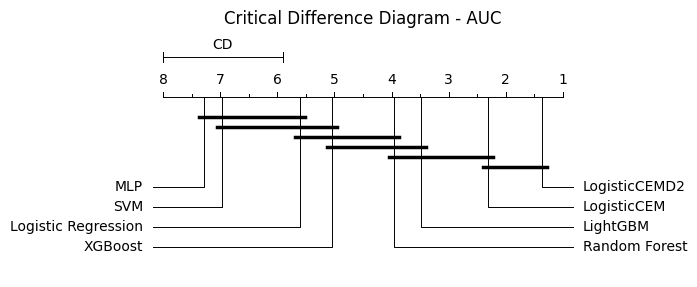

The statistical analysis was conducted for 8 populations with 25 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.286). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.000) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference

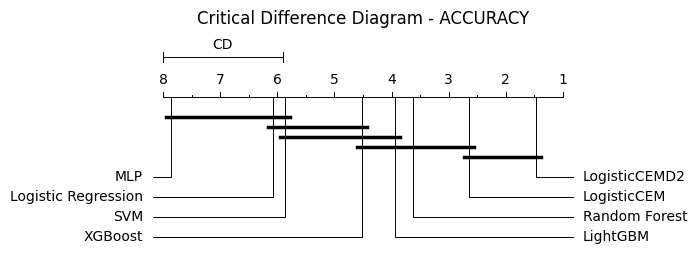

The statistical analysis was conducted for 8 populations with 25 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population XGBoost (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.100 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in t

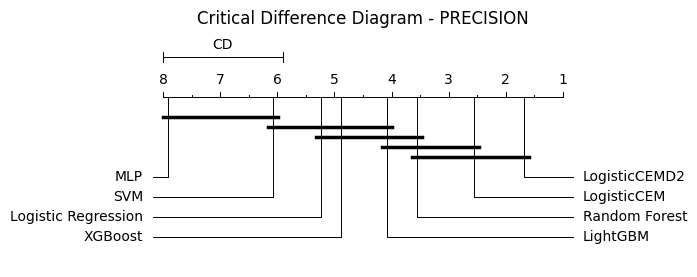

The statistical analysis was conducted for 8 populations with 25 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population SVM (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.100 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in the c

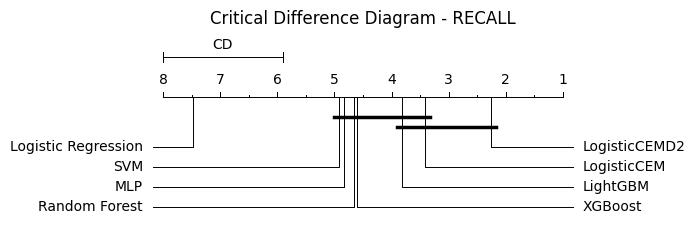

The statistical analysis was conducted for 8 populations with 25 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population MLP (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.100 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in the c

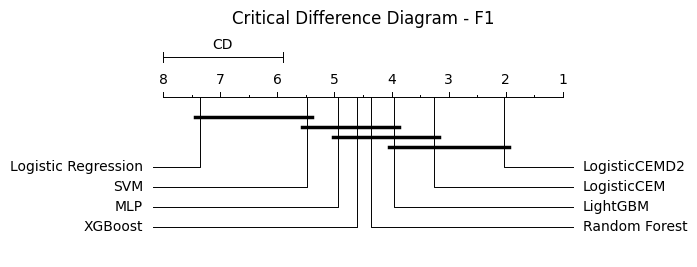

The statistical analysis was conducted for 8 populations with 25 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population MLP (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=2.100 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in the c

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from autorank import autorank, plot_stats, create_report
import matplotlib.pyplot as plt

# from your_module import LogisticCEMClassifier, LogisticCEMd2

# Définir les modèles
models = {
    "LogisticCEMD2": LogisticCEMd2(learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0,
                 use_interactions=True, interactions_only=False, random_state=42,
                 early_stopping=True, n_jobs=-1, penalty='l1'),
    "Logistic Regression": LogisticRegression(max_iter=500, solver='saga'),
    "MLP": MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LogisticCEM": LogisticCEMClassifier() }

# Initialiser les métriques
results = {
    'auc': {model: [] for model in models},
    'accuracy': {model: [] for model in models},
    'precision': {model: [] for model in models},
    'recall': {model: [] for model in models},
    'f1': {model: [] for model in models}
}

# Liste pour sauvegarder chaque résultat dans un seul dataframe
full_training_log = []

# Créer un dossier pour sauvegarder les datasets
os.makedirs("train_runs", exist_ok=True)

# Boucle principale
for i in range(25):
    print(f"\n🔄 Itération {i+1} / 25")

    # Échantillonnage
    X_rejected_sample = loans_rejected.sample(n=25000, random_state=42)

    class_0 = loans_accepted[loans_accepted["Class"] == 0]
    class_1 = loans_accepted[loans_accepted["Class"] == 1]

    class_0_sample = class_0.sample(n=1000, random_state=42)
    class_1_sample = class_1.sample(n=1000, random_state=42)

    loans_accepted_balanced_1 = pd.concat([class_0_sample, class_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        loans_accepted_balanced_1.drop(columns=["Class"]),
        loans_accepted_balanced_1["Class"],
        test_size=0.2,
        stratify=loans_accepted_balanced_1["Class"]
    )

    # Ajouter rejetés
    X_train_full = pd.concat([X_train, X_rejected_sample])
    y_rejected = pd.Series([-1] * len(X_rejected_sample), index=X_rejected_sample.index)
    y_train_full = pd.concat([y_train, y_rejected])

    # Sauvegarde dans un fichier CSV
    train_data_save = X_train_full.copy()
    train_data_save["Class"] = y_train_full
    train_data_save.to_csv(f"train_runs/train_data_run_{i+1}.csv", index=False)

    # Entraînement et évaluation
    for name, model in models.items():
        if name in ["LogisticCEMD2", "LogisticCEM","LogisticCEMD2plus"]:
            model.fit(X_train_full[y_train_full != -1], y_train_full[y_train_full != -1], X_train_full[y_train_full == -1])
        else:
            model.fit(X_train_full[y_train_full != -1], y_train_full[y_train_full != -1])

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Sauvegarder les résultats
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results['auc'][name].append(auc)
        results['accuracy'][name].append(accuracy)
        results['precision'][name].append(precision)
        results['recall'][name].append(recall)
        results['f1'][name].append(f1)

        # Ajouter à full_training_log
        full_training_log.append({
            'Run': i + 1,
            'Model': name,
            'AUC': auc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

# Après toutes les itérations : sauvegarde du fichier CSV avec tous les runs
full_training_log_df = pd.DataFrame(full_training_log)
full_training_log_df.to_csv("train_runs/all_training_results.csv", index=False)

print("\n✅ Tous les résultats détaillés ont été sauvegardés dans 'train_runs/all_training_results.csv'.")

# Résumé des résultats
summary_table = pd.DataFrame({
    'Model': list(models.keys()),
    'AUC': [np.mean(results['auc'][model]) for model in models],
    'Accuracy': [np.mean(results['accuracy'][model]) for model in models],
    'Precision': [np.mean(results['precision'][model]) for model in models],
    'Recall': [np.mean(results['recall'][model]) for model in models],
    'F1-Score': [np.mean(results['f1'][model]) for model in models]
}).round(4)

print("\n📋 Tableau des moyennes des métriques sur 25 runs :\n")
print(summary_table)

# Analyse statistique avec autorank
for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
    print(f"\n📈 Analyse Autorank pour la métrique : {metric.upper()}")
    metric_df = pd.DataFrame(results[metric])
    rank_result = autorank(metric_df, alpha=0.05, verbose=False)
    plot_stats(rank_result)
    plt.title(f"Critical Difference Diagram - {metric.upper()}")
    plt.tight_layout()
    plt.show()
    print(create_report(rank_result))


# 50 reps


🔄 Itération 1 / 50


  2%|▏         | 3/200 [00:07<07:50,  2.39s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 2 / 50


  2%|▏         | 3/200 [00:08<09:24,  2.87s/it]


Early stopping at iteration 4: No significant improvement for 3 iterations
[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 561
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 3 / 50


  2%|▏         | 4/200 [00:12<10:23,  3.18s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 4 / 50


  2%|▏         | 4/200 [00:08<07:02,  2.15s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 5 / 50


  2%|▏         | 3/200 [00:06<07:22,  2.24s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 6 / 50


  2%|▏         | 4/200 [00:08<07:04,  2.17s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 7 / 50


  2%|▏         | 3/200 [00:08<09:31,  2.90s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 8 / 50


  2%|▏         | 3/200 [00:06<07:32,  2.30s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 9 / 50


  2%|▏         | 4/200 [00:12<09:49,  3.01s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 10 / 50


  2%|▏         | 3/200 [00:10<11:48,  3.60s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 11 / 50


  2%|▏         | 4/200 [00:09<07:41,  2.35s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 12 / 50


  2%|▏         | 3/200 [00:06<07:37,  2.32s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 548
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 13 / 50


  2%|▏         | 4/200 [00:07<05:49,  1.78s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 14 / 50


  2%|▏         | 4/200 [00:14<12:12,  3.74s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 15 / 50


  2%|▏         | 3/200 [00:07<07:56,  2.42s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 16 / 50


  2%|▏         | 3/200 [00:08<09:15,  2.82s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 17 / 50


  2%|▏         | 3/200 [00:06<06:42,  2.04s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 18 / 50


  2%|▏         | 4/200 [00:10<08:56,  2.74s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 19 / 50


  2%|▏         | 4/200 [00:07<06:06,  1.87s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 20 / 50


  2%|▏         | 3/200 [00:08<08:58,  2.73s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 21 / 50


  2%|▏         | 3/200 [00:06<07:19,  2.23s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 22 / 50


  2%|▏         | 3/200 [00:07<08:34,  2.61s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 23 / 50


  2%|▏         | 3/200 [00:07<08:19,  2.54s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 24 / 50


  2%|▏         | 3/200 [00:07<08:01,  2.45s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 25 / 50


  2%|▏         | 3/200 [00:07<08:22,  2.55s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 26 / 50


  2%|▏         | 3/200 [00:06<07:39,  2.33s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 27 / 50


  2%|▏         | 3/200 [00:07<07:47,  2.37s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 28 / 50


  2%|▏         | 3/200 [00:12<14:09,  4.31s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 29 / 50


  2%|▏         | 3/200 [00:08<08:58,  2.73s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 30 / 50


  2%|▏         | 4/200 [00:11<09:18,  2.85s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 31 / 50


  2%|▏         | 3/200 [00:06<06:44,  2.05s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 32 / 50


  2%|▏         | 3/200 [00:13<14:57,  4.56s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 33 / 50


  2%|▏         | 3/200 [00:05<06:18,  1.92s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 34 / 50


  2%|▏         | 3/200 [00:05<05:32,  1.69s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 35 / 50


  2%|▏         | 3/200 [00:05<05:58,  1.82s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 36 / 50


  2%|▏         | 3/200 [00:06<06:34,  2.00s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 37 / 50


  2%|▏         | 3/200 [00:07<07:40,  2.34s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 38 / 50


  2%|▏         | 3/200 [00:06<07:10,  2.18s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 39 / 50


  2%|▏         | 4/200 [00:08<07:19,  2.24s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 40 / 50


  2%|▏         | 4/200 [00:07<05:56,  1.82s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 41 / 50


  2%|▏         | 3/200 [00:05<06:13,  1.90s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 42 / 50


  2%|▏         | 3/200 [00:06<07:20,  2.23s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 43 / 50


  2%|▏         | 3/200 [00:05<05:42,  1.74s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 44 / 50


  2%|▏         | 3/200 [00:05<05:43,  1.74s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 45 / 50


  2%|▏         | 4/200 [00:07<06:02,  1.85s/it]

Early stopping at iteration 5: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 46 / 50


  2%|▏         | 3/200 [00:04<05:27,  1.66s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 47 / 50


  2%|▏         | 3/200 [00:05<06:07,  1.86s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 48 / 50


  2%|▏         | 3/200 [00:05<05:39,  1.73s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 49 / 50


  2%|▏         | 3/200 [00:05<06:04,  1.85s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

🔄 Itération 50 / 50


  2%|▏         | 3/200 [00:05<06:06,  1.86s/it]

Early stopping at iteration 4: No significant improvement for 3 iterations


[LightGBM] [Info] Number of positive: 800, number of negative: 800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

✅ Tous les résultats détaillés ont été sauvegardés dans 'train_runs/all_training_results.csv'.

📋 Tableau des moyennes des métriques sur 50 runs :

                 Model     AUC  Accuracy  Precision  Recall  F1-Score
0        LogisticCEMD2  0.6560    0.6140     0.6082  0.6418    0.6242
1  Logistic Regression  0.5694    0.5442     0.5570  0.4387    0.4901
2                  MLP  0.5068    0.5024     0.3102  0.4032    0.2851
3                  SVM  0.5613    0.5474     0.5446  0.5811    0.5616
4    

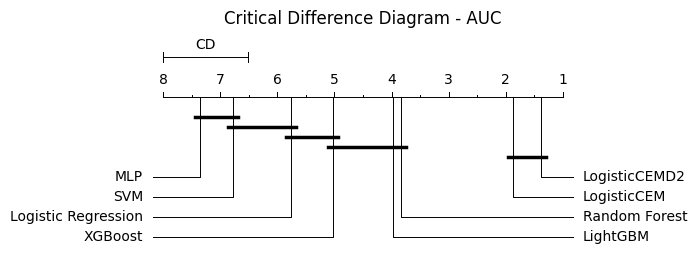

The statistical analysis was conducted for 8 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.030). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.000) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference

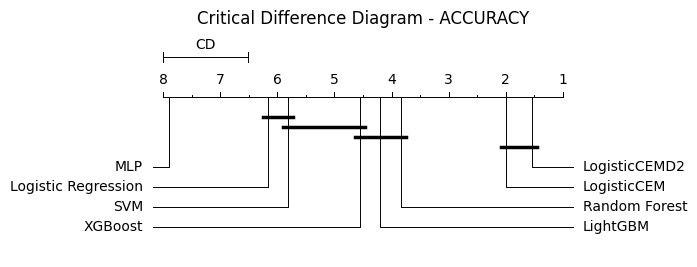

The statistical analysis was conducted for 8 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population XGBoost (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.485 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in t

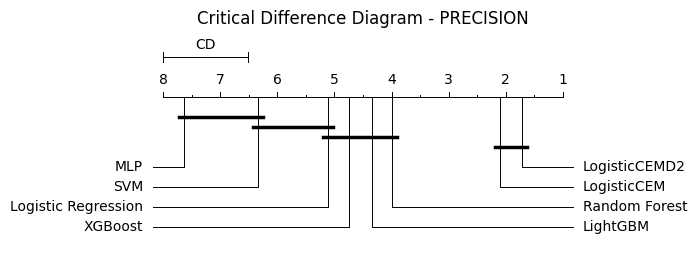

The statistical analysis was conducted for 8 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population SVM (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.485 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in the c

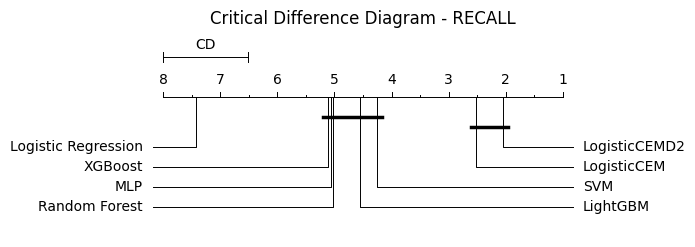

The statistical analysis was conducted for 8 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population MLP (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.485 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference in the c

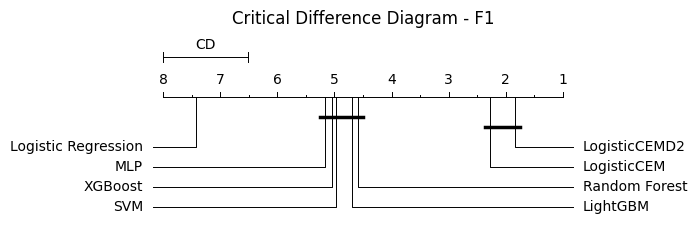

The statistical analysis was conducted for 8 populations with 50 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the population LogisticCEM (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and one of them is not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.485 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no difference 

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from autorank import autorank, plot_stats, create_report
import matplotlib.pyplot as plt

# from your_module import LogisticCEMClassifier, LogisticCEMd2

# Définir les modèles
models = {
    "LogisticCEMD2": LogisticCEMd2(learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0,
                 use_interactions=True, interactions_only=False, random_state=42,
                 early_stopping=True, n_jobs=-1, penalty='l1'),
    "Logistic Regression": LogisticRegression(max_iter=500, solver='saga'),
    "MLP": MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=500),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LogisticCEM": LogisticCEMClassifier() }

# Initialiser les métriques
results = {
    'auc': {model: [] for model in models},
    'accuracy': {model: [] for model in models},
    'precision': {model: [] for model in models},
    'recall': {model: [] for model in models},
    'f1': {model: [] for model in models}
}

# Liste pour sauvegarder chaque résultat dans un seul dataframe
full_training_log = []

# Créer un dossier pour sauvegarder les datasets
os.makedirs("train_runs", exist_ok=True)

# Boucle principale
for i in range(50):
    print(f"\n🔄 Itération {i+1} / 50")

    # Échantillonnage
    X_rejected_sample = loans_rejected.sample(n=25000, random_state=42)

    class_0 = loans_accepted[loans_accepted["Class"] == 0]
    class_1 = loans_accepted[loans_accepted["Class"] == 1]

    class_0_sample = class_0.sample(n=1000, random_state=42)
    class_1_sample = class_1.sample(n=1000, random_state=42)

    loans_accepted_balanced_1 = pd.concat([class_0_sample, class_1_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        loans_accepted_balanced_1.drop(columns=["Class"]),
        loans_accepted_balanced_1["Class"],
        test_size=0.2,
        stratify=loans_accepted_balanced_1["Class"]
    )

    # Ajouter rejetés
    X_train_full = pd.concat([X_train, X_rejected_sample])
    y_rejected = pd.Series([-1] * len(X_rejected_sample), index=X_rejected_sample.index)
    y_train_full = pd.concat([y_train, y_rejected])

    # Sauvegarde dans un fichier CSV
    train_data_save = X_train_full.copy()
    train_data_save["Class"] = y_train_full
    train_data_save.to_csv(f"train_runs/train_data_run_{i+1}.csv", index=False)

    # Entraînement et évaluation
    for name, model in models.items():
        if name in ["LogisticCEMD2", "LogisticCEM","LogisticCEMD2plus"]:
            model.fit(X_train_full[y_train_full != -1], y_train_full[y_train_full != -1], X_train_full[y_train_full == -1])
        else:
            model.fit(X_train_full[y_train_full != -1], y_train_full[y_train_full != -1])

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Sauvegarder les résultats
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results['auc'][name].append(auc)
        results['accuracy'][name].append(accuracy)
        results['precision'][name].append(precision)
        results['recall'][name].append(recall)
        results['f1'][name].append(f1)

        # Ajouter à full_training_log
        full_training_log.append({
            'Run': i + 1,
            'Model': name,
            'AUC': auc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

# Après toutes les itérations : sauvegarde du fichier CSV avec tous les runs
full_training_log_df = pd.DataFrame(full_training_log)
full_training_log_df.to_csv("train_runs/all_training_results.csv", index=False)

print("\n✅ Tous les résultats détaillés ont été sauvegardés dans 'train_runs/all_training_results.csv'.")

# Résumé des résultats
summary_table = pd.DataFrame({
    'Model': list(models.keys()),
    'AUC': [np.mean(results['auc'][model]) for model in models],
    'Accuracy': [np.mean(results['accuracy'][model]) for model in models],
    'Precision': [np.mean(results['precision'][model]) for model in models],
    'Recall': [np.mean(results['recall'][model]) for model in models],
    'F1-Score': [np.mean(results['f1'][model]) for model in models]
}).round(4)

print("\n📋 Tableau des moyennes des métriques sur 50 runs :\n")
print(summary_table)

# Analyse statistique avec autorank
for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
    print(f"\n📈 Analyse Autorank pour la métrique : {metric.upper()}")
    metric_df = pd.DataFrame(results[metric])
    rank_result = autorank(metric_df, alpha=0.05, verbose=False)
    plot_stats(rank_result)
    plt.title(f"Critical Difference Diagram - {metric.upper()}")
    plt.tight_layout()
    plt.show()
    print(create_report(rank_result))


In [ ]:
import measfgjjsdrgi as fwkgij

ModuleNotFoundError: No module named 'measfgjjsdrgi'

 51%|█████     | 102/200 [00:09<00:08, 11.31it/s]


Early stopping at iteration 103: No significant improvement for 3 iterations


 24%|██▍       | 48/200 [00:05<00:17,  8.91it/s]


Early stopping at iteration 49: No significant improvement for 3 iterations


 11%|█         | 22/200 [00:04<00:39,  4.56it/s]


Early stopping at iteration 23: No significant improvement for 3 iterations


 11%|█         | 22/200 [00:07<01:00,  2.95it/s]


Early stopping at iteration 23: No significant improvement for 3 iterations


 11%|█         | 22/200 [00:10<01:24,  2.10it/s]


Early stopping at iteration 23: No significant improvement for 3 iterations


 21%|██        | 42/200 [00:30<01:55,  1.37it/s]


Early stopping at iteration 43: No significant improvement for 3 iterations


 12%|█▏        | 23/200 [00:17<02:11,  1.35it/s]

Early stopping at iteration 24: No significant improvement for 3 iterations


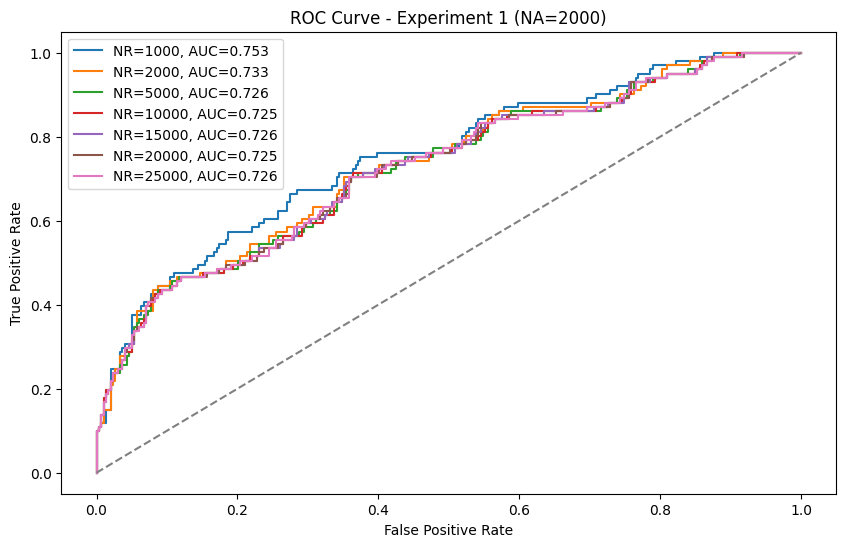

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd

# Features and labels
X_accepted = loans_accepted_balanced.drop(columns=['Class']).values
y_accepted = loans_accepted_balanced['Class'].values

X_rejected = loans_rejected

# Experiment 1: NA = 2000, NR varies from 1000 to 25000
NR_values_1 = [1000,2000,5000,10000,15000,20000,25000]
plt.figure(figsize=(10, 6))
X_accepted_sample = X_accepted[:2000]
y_accepted_sample = y_accepted[:2000]
X_train, X_test, y_train, y_test = train_test_split(X_accepted_sample, y_accepted_sample, test_size=0.2, random_state=42)

# Define a list to store handles and labels for the legend
handles = []
labels = []

for NR in NR_values_1:
    X_rejected_sample = X_rejected[:NR]
    model = LogisticCEMd2(learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0, 
                           use_interactions=True, interactions_only=False, early_stopping=True, n_jobs=-1)
    model.fit(X_train, y_train, X_rejected_sample)
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot each curve
    line, = plt.plot(fpr, tpr, label=f"NR={NR}, AUC={roc_auc:.3f}")
    
    # Add the current line to the handles and labels
    handles.append(line)
    labels.append(f"NR={NR}, AUC={roc_auc:.3f}")

# Add diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Label the axes and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Experiment 1 (NA=2000)")

# Add the legend
plt.legend(handles=handles, labels=labels)

# Show the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm import tqdm

class LogisticCEMd2(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0, 
                 use_interactions=True, interactions_only=False, random_state=42,
                  early_stopping=True, n_jobs=-1):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.epsilon = epsilon  # Tightened convergence threshold
        self.degree = degree    # Increased polynomial degree
        self.C = C              # Regularization strength
        self.use_interactions = use_interactions  
        self.interactions_only = interactions_only
        self.random_state = random_state
        self.early_stopping = early_stopping  # Early stopping option
        self.n_jobs = n_jobs    # Parallel processing
        self.poly = None        # Polynomial transformer
        self.scaler = None      # Feature scaler
        self.G_j = None         # Logistic Regression model
        self.best_likelihood = -np.inf
        self.no_improvement_count = 0
        
    def _apply_polynomial_features(self, X):
        """Apply polynomial feature transformation with scaling."""
        if self.poly is None:
            self.poly = PolynomialFeatures(degree=self.degree, 
                                           include_bias=False, 
                                           interaction_only=self.interactions_only)
            self.poly.fit(X)
            
        X_poly = self.poly.transform(X)
        
        if self.scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(X_poly)
            
        return self.scaler.transform(X_poly)

    def fit(self, X_l, y_l, X_u, sample_weight_l=None, validation_data=None, patience=1):
        """Train the model using labeled and unlabeled data with improved methodology."""
        # Transform features
        X_l_poly = self._apply_polynomial_features(X_l)
        X_u_poly = self._apply_polynomial_features(X_u)
        
        # Setup validation if provided
        if validation_data:
            X_val, y_val = validation_data
            X_val_poly = self._apply_polynomial_features(X_val)
        
        # Initial logistic regression on labeled data
        self.G_j = LogisticRegression(
            C=self.C, 
            max_iter=3000, 
            solver='liblinear',  # Changed to saga for better handling of large feature sets
            random_state=self.random_state,
            n_jobs=self.n_jobs
        )
        self.G_j.fit(X_l_poly, y_l,sample_weight=sample_weight_l)
        
        # EM iterations
        prev_log_likelihood = -np.inf
        no_improvement_counter = 0
        
        for j in tqdm(range(self.max_iter)):
            # E-Step: Estimate posterior probabilities
            p1_j, p2_j = self._compute_posterior(X_u_poly)
            
            # C-Step: Classify unlabeled data with confidence weighting
            z_ki, weights_u = self._classification_step(p1_j, p2_j)
            
            # M-Step: Maximize log-likelihood with weighted samples using gradient descent
            self._maximize_log_likelihood(X_l_poly, y_l, X_u_poly, z_ki, sample_weight_l, weights_u)
            
            # Compute log-likelihood for stopping condition
            current_log_likelihood = self._log_likelihood(X_l_poly, y_l, X_u_poly, z_ki)
            
            # Early stopping logic
            improvement = current_log_likelihood - prev_log_likelihood
            
            if improvement < self.epsilon:
                no_improvement_counter += 1
                if self.early_stopping and no_improvement_counter >= patience:
                    print(f"Early stopping at iteration {j+1}: No significant improvement for {patience} iterations")
                    break
            else:
                no_improvement_counter = 0
                
            prev_log_likelihood = current_log_likelihood
            
        return self

    def predict(self, X_test):
        """Predict labels for test data."""
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G_j.predict(X_test_poly)

    def predict_proba(self, X_test):
        """Predict probabilities for test data."""
        X_test_poly = self._apply_polynomial_features(X_test)
        return self.G_j.predict_proba(X_test_poly)

    def _compute_posterior(self, X_u):
        """Compute posterior probabilities."""
        proba = self.G_j.predict_proba(X_u)
        return proba[:, 1], proba[:, 0]

    def _classification_step(self, p1_j, p2_j):
        """Assign labels to unlabeled data with confidence weights."""
        # Assign class based on higher probability
        z_ki = (p1_j > p2_j).astype(int)
        
        # Confidence weights based on probability difference
        # Higher confidence = larger gap between probabilities
        weights = np.abs(p1_j - p2_j)
        
        return z_ki, weights

    def _maximize_log_likelihood(self, X_l, y_l, X_u, z_ki, sample_weight_l=None, weights_u=None):
        """Re-train logistic regression with weighted pseudo-labels using gradient descent."""
        X_combined = np.vstack([X_l, X_u])
        y_combined = np.hstack([y_l, z_ki])
        
        # Combine sample weights
        if sample_weight_l is None:
            sample_weight_l = np.ones(len(y_l))
            
        combined_weights = np.hstack([sample_weight_l, weights_u])
        
        # Compute gradients (gradient descent step)
        gradient, intercept_gradient = self._compute_gradients(X_combined, y_combined, self.G_j.coef_, self.G_j.intercept_)
        
        # Update coefficients using gradient descent
        self.G_j.coef_ -= self.learning_rate * gradient
        self.G_j.intercept_ -= self.learning_rate * intercept_gradient
        
        # Fit the model after gradient update (can also be done if necessary)
        self.G_j.fit(X_combined, y_combined, sample_weight=combined_weights)

    def _log_likelihood(self, X_l, y_l, X_u, z_ki):
        """Compute log-likelihood with regularization penalty."""
        l_proba = self.G_j.predict_proba(X_l)
        u_proba = self.G_j.predict_proba(X_u)
        
        # Log likelihood for labeled and unlabeled data
        ll_labeled = sum(np.log(np.maximum(l_proba[i, y], 1e-10)) for i, y in enumerate(y_l))
        ll_unlabeled = sum(np.log(np.maximum(u_proba[i, z], 1e-10)) for i, z in enumerate(z_ki))
        
        # Add L2 regularization penalty
        coef = self.G_j.coef_.ravel()
        reg_penalty = -0.5 * (1/self.C) * np.sum(coef**2)
        
        return ll_labeled + ll_unlabeled + reg_penalty

    def _compute_gradients(self, X, y, coef, intercept):
        """Compute gradients for logistic regression using the current model parameters."""
        # Compute the probabilities of the current model
        proba = self.G_j.predict_proba(X)
        
        # Compute the error term (difference between predicted probabilities and actual labels)
        error = proba[:, 1] - y
        
        # Compute the gradient for coefficients
        gradient = np.dot(X.T, error) / X.shape[0]
        
        # Compute the gradient for the intercept
        intercept_gradient = np.sum(error) / X.shape[0]
        
        return gradient, intercept_gradient


In [ ]:
loans_accepted_balanced.shape

(2038712, 10)

  0%|          | 1/200 [04:09<13:48:44, 249.87s/it]

Early stopping at iteration 2: No significant improvement for 1 iterations



  0%|          | 1/200 [05:03<16:47:56, 303.90s/it]

Early stopping at iteration 2: No significant improvement for 1 iterations



  8%|▊         | 15/200 [53:17<10:57:17, 213.17s/it]

Early stopping at iteration 16: No significant improvement for 1 iterations



  9%|▉         | 18/200 [1:30:28<15:14:44, 301.57s/it]

Early stopping at iteration 19: No significant improvement for 1 iterations



 24%|██▍       | 48/200 [2:43:21<8:37:17, 204.20s/it]

Early stopping at iteration 49: No significant improvement for 1 iterations


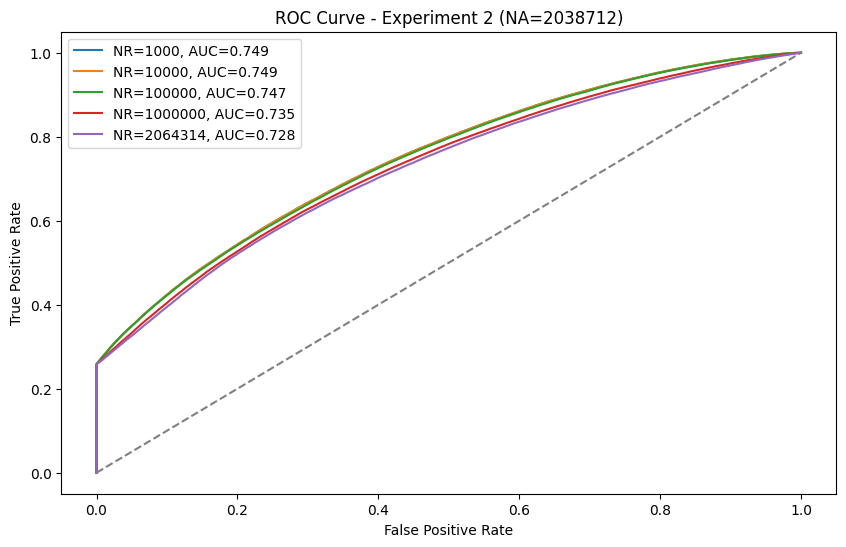

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd

# Features and labels
X_accepted = loans_accepted_balanced.drop(columns=['Class']).values
y_accepted = loans_accepted_balanced['Class'].values

X_rejected = loans_rejected

# Experiment 2: NA = 1,266,782, NR varies from 1000 to 2,064,314
NR_values_2 = [1000,10000,100000,1000000,2064314]
plt.figure(figsize=(10, 6))
X_accepted_sample = X_accepted[:2038712]
y_accepted_sample = y_accepted[:2038712]
X_train, X_test, y_train, y_test = train_test_split(X_accepted_sample, y_accepted_sample, test_size=0.3, random_state=42)

# Define a list to store handles and labels for the legend
handles = []
labels = []

for NR in NR_values_2:
    X_rejected_sample = X_rejected[:NR]
    model = LogisticCEMd2(learning_rate=0.01, max_iter=200, epsilon=1e-5, degree=2, C=1.0, 
                           use_interactions=True, interactions_only=False, early_stopping=True, n_jobs=-1)
    model.fit(X_train, y_train, X_rejected_sample)
    
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot each curve
    line, = plt.plot(fpr, tpr, label=f"NR={NR}, AUC={roc_auc:.3f}")
    
    # Add the current line to the handles and labels
    handles.append(line)
    labels.append(f"NR={NR}, AUC={roc_auc:.3f}")

# Add diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Label the axes and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Experiment 2 (NA=2038712)")

# Add the legend
plt.legend(handles=handles, labels=labels)

# Show the plot
plt.show()
